In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

/mydrive


In [ ]:
!ls

drive  sample_data


In [4]:
%cd ..

/


In [ ]:
!ls

 CrawlerImage_ID_1.ipynb       'Netflix Movie Recommendation.ipynb'
 CrawlerImage_ID_2.ipynb        network_analysis_4.ipynb
 data.csv		       'Network Analysis Homework1.ipynb'
 Homework2.ipynb	        Untitled
 homework3.ipynb	        Untitled0.ipynb
'Homework4 3(a)(b)(c).ipynb'   'Zip 函数及其他各种操作.ipynb'
 Homework4.ipynb	        天津公交站分布.ipynb
 homework5.ipynb	        小世界网络.ipynb
 Netflix_Movie_Recommendation


In [5]:
%cd content/drive/MyDrive/Colab Notebooks/Netflix_Movie_Recommendation

/content/drive/MyDrive/Colab Notebooks/Netflix_Movie_Recommendation


In [91]:
from datetime import datetime 
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.linalg import sqrtm

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

<h1> Exploratory Data Analysis </h1>

<h2> Preprocessing</h2> 

<h3>Converting / Merging whole data to required format: u_i, m_j, r_ij</h3>

In [ ]:
!ls

 CrawlerImage_ID_1.ipynb       'Netflix Movie Recommendation.ipynb'
 CrawlerImage_ID_2.ipynb        network_analysis_4.ipynb
 data.csv		       'Network Analysis Homework1.ipynb'
 Homework2.ipynb	        Untitled
 homework3.ipynb	        Untitled0.ipynb
'Homework4 3(a)(b)(c).ipynb'   'Zip 函数及其他各种操作.ipynb'
 Homework4.ipynb	        天津公交站分布.ipynb
 homework5.ipynb	        小世界网络.ipynb
 Netflix_Movie_Recommendation


In [ ]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Creating a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']

    for file in files:

        print("Reading ratings from {}...".format(file))

        with open(file) as f:
            for line in f: 
                del row[:] # We might not have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")

    data.close()

print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000559


In [7]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [ ]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [ ]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<h3>Checking for NaN values </h3>

In [ ]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


<h3>Removing Duplicates </h3>

In [ ]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


 <h3>Basic Statistics (#Ratings, #Users, and #Movies)</h3>

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


<h2>Spliting data into Train and Test(80:20) </h2>

In [32]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head(3)

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11


<h3>Basic Statistics in Train data (#Ratings, #Users, and #Movies)</h3>

In [ ]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


<h3>Basic Statistics in Test data (#Ratings, #Users, and #Movies)</h3>

In [ ]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


<h3> Creating sparse matrix from data frame </h3>

<h4> Creating sparse matrix from train data frame </h4>

In [ ]:
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


In [8]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk in the local system instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:06.912356


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [9]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


<h4> Creating sparse matrix from test data frame </h4>

In [10]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # If the sparse matrix has been created and saved previosuly, just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It is in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:03.305975


<p><b>The Sparsity of Test data Matrix</b></p>

In [11]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


<h3>Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [12]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

<h4> Finding global average of all movie ratings </h4>

In [ ]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

<h4> Finding average rating per user</h4>

In [ ]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


<h4> Finding average rating per movie</h4>

In [ ]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


In [ ]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


In [ ]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


> We might have to handle __346 movies__ (comparatively small) in test data

 <h1> Machine Learning Models </h1>

In [13]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It is just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask of these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for further usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h2> Sampling Data </h2>

<h3>Build sample train data from the train data</h3>

In [14]:
start = datetime.now()
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.792715


<h3>Build sample test data from the test data</h3>

In [15]:
start = datetime.now()

path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.920474


<h2>Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [16]:
sample_train_averages = dict()

<h3>Finding Global Average of all movie ratings</h3>

In [17]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

<h3>Finding Average rating per User</h3>

In [18]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9655172413793105


<h3>Finding Average rating per Movie</h3>

In [19]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.6458333333333335


<h2> Featurizing data </h2>

In [20]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 129286


 No of ratings in Our Sampled test  matrix is : 7333



<h3> Featurizing data for regression problem </h3>

<h4> Featurizing train data </h4>

In [21]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [22]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists we don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stored in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists we don't have to prepare again...
0:00:00.001529


__Reading from the file to make a Train_dataframe__

In [23]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h4> Featurizing test data </h4>

In [24]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [25]:
sample_train_averages['global']

3.581679377504138

In [26]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


__Reading from the file to make a test dataframe __

In [27]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h3> Transforming data for Surprise models</h3>

In [28]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633976 sha256=526cf19b29969cea789cfea9dd47c1878bc1e9381d15f7d4257a691b198545e4
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [29]:
from surprise import Reader, Dataset

<h4> Transforming train data </h4>

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [30]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

<h4> Transforming test data </h4>

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant) 

In [33]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

In [34]:
train_data_A1 = reg_train[['user', 'movie', 'rating']]
test_data_A1 = reg_test_df[['user', 'movie', 'rating']]

In [ ]:
train_data_A1.head()

,user,movie,rating
0,53406,33,4
1,99540,33,3
2,99865,33,5
3,101620,33,5
4,112974,33,5


In [ ]:
test_data_A1.head()

,user,movie,rating
0,808635,71,5
1,941866,71,4
2,1737912,71,3
3,1849204,71,4
4,28572,111,1


<h2>Applying Machine Learning models </h2>

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [35]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

 > __Utility functions for running regression models__

In [40]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results, y_test_pred
    

> __Utility functions for Surprise modes__

In [52]:
# This is just to makesure that all of our algorithms should produce same results everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# Get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# Get ''rmse'' and ''mape'' , given list of prediction objecs  #
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# This will return predicted ratings, rmse and mape of both train and test data  #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')

    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())

    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)

    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)

    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test, test_actual_ratings, test_pred_ratings

<h3> XGBoost with initial 13 features </h3>

In [38]:
import xgboost as xgb

In [41]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results, predictions_b1 = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

Training the model..
[00:16:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:02.863780

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.076373581778953
MAPE :  34.48223172520999


<IPython.core.display.Javascript object>

In [59]:
b1_rmse=1.0764
b1_mape=34.482

In [48]:
rating_b1_csv=pd.DataFrame(data=y_test)
prediction_b1_csv=pd.DataFrame(data=predictions_b1)
rating_b1_csv.to_csv('rating_b1.csv',encoding='utf-8')
prediction_b1_csv.to_csv('prediction_b1.csv',encoding='utf-8')

<h3> Surprise KNNBaseline predictor </h3>

In [49]:
from surprise import KNNBaseline

  <h4> Surprise KNNBaseline with user user similarities</h4>

In [53]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results, rating_b2, prediction_b2 = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:27.627739 

Evaluating the model with train data..
time taken : 0:01:45.550633
---------------
Train Data
---------------
RMSE : 0.33642097416508826

MAPE : 9.145093375416348

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.078705
---------------
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:13.257687


In [60]:
b2_rmse=1.0726
b2_mape=35.021

In [54]:
rating_b2_csv=pd.DataFrame(data=rating_b2)
prediction_b2_csv=pd.DataFrame(data=prediction_b2)
rating_b2_csv.to_csv('rating_b2.csv',encoding='utf-8')
prediction_b2_csv.to_csv('prediction_b2.csv',encoding='utf-8')

<h3> Matrix Factorization Techniques </h3>

<h4> SVD Matrix Factorization User Movie interactions </h4>

In [55]:
from surprise import SVD

In [56]:
# initiallize the model
svd = SVD(n_factors=100, biased=False, random_state=15, verbose=True)
svd_train_results, svd_test_results, rating_b3, prediction_b3 = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:07.997846 

Evaluating the model with train data..
time taken : 0:00:01.449780
---------------
Train Data
---------------
RMSE : 0.6330909501027698

MAPE : 18.001060243744398

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.076150
---------------
Test Data
---------------
RMSE : 1.075063163782051

MAPE : 35.15593514504269

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.525157


In [61]:
b3_rmse=1.0751
b3_mape=35.156

In [57]:
rating_b3_csv=pd.DataFrame(data=rating_b3)
prediction_b3_csv=pd.DataFrame(data=prediction_b3)
rating_b3_csv.to_csv('rating_b3.csv',encoding='utf-8')
prediction_b3_csv.to_csv('prediction_b3.csv',encoding='utf-8')

<h4> SVD Matrix Factorization User Movie interactions with bias </h4>

In [ ]:
# train_data_A1 user	movie	rating

In [ ]:
train_data_A1.head()

,user,movie,rating
0,53406,33,4
1,99540,33,3
2,99865,33,5
3,101620,33,5
4,112974,33,5


In [ ]:
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


In [ ]:
a={'8':[[1,2]],'9':[[3,4],[5,6]],'10':[[]]}
# avg=np.mean([a[user_id][0] for user_id in a.keys()])
# avg
# for key in a.keys():
#   for movie in a[key]:
#     print(key, movie[0])
  #print(a[key][0][0])
lista=list(a.keys())
np.random.permutation(lista)

array(['10', '9', '8'], dtype='<U2')

In [ ]:
!ls

data.csv			     sample_test_sparse_matrix.npz
data_folder			     sample_train_sparse_matrix.npz
dict.json			     test.csv
Netflix_Movie_Recommendation1.ipynb  test_sparse_matrix.npz
reg_test.csv			     train.csv
reg_train.csv			     train_sparse_matrix.npz


In [9]:
from collections import defaultdict
import json
def create_movie_user_dict_train(df):

    if not os.path.isfile('movie_user_train.json'):
        movie_user = defaultdict(list)
        # count=0
        for iter, row in df.iterrows():
            # count+=1
            # if count%10000==0:
            #   print(count)
            movie_user[row[0]].append([row[1], row[2]])
        my_json = json.dumps(movie_user)
        f = open("movie_user_train.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('movie_user_train.json') as json_file:
          movie_user = json.load(json_file)
    print('movie_user_train.json loaded')
    return movie_user

def create_user_movie_dict_train(df):

    if not os.path.isfile('user_movie_train.json'):
        user_movie = defaultdict(list)
        for iter, row in df.iterrows():
            user_movie[row[1]].append([row[0], row[2]])
        my_json = json.dumps(user_movie)
        f = open("user_movie_train.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('user_movie_train.json') as json_file:
          user_movie = json.load(json_file)
    print('user_movie_train.json loaded')
    return user_movie

def create_movie_user_dict_test(df):

    if not os.path.isfile('movie_user_test.json'):
        movie_user = defaultdict(list)
        for iter, row in df.iterrows():
            movie_user[row[0]].append([row[1], row[2]])
        my_json = json.dumps(movie_user)
        f = open("movie_user_test.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('movie_user_test.json') as json_file:
          movie_user = json.load(json_file)
    print('movie_user_test.json loaded')
    return movie_user

def create_user_movie_dict_test(df):

    if not os.path.isfile('user_movie_test.json'):
        user_movie = defaultdict(list)
        for iter, row in df.iterrows():
            user_movie[row[1]].append([row[0], row[2]])
        my_json = json.dumps(user_movie)
        f = open("user_movie_test.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('user_movie_test.json') as json_file:
          user_movie = json.load(json_file)
    print('user_movie_test.json loaded')
    return user_movie

In [10]:
import gc

In [11]:
movie_user_train = create_movie_user_dict_train(train_df)
gc.collect()

opening json file
movie_user_train.json loaded


0

In [12]:
user_movie_train = create_user_movie_dict_train(train_df)
gc.collect()

opening json file
user_movie_train.json loaded


0

In [13]:
movie_user_test = create_movie_user_dict_test(test_df)
gc.collect()

opening json file
movie_user_test.json loaded


0

In [14]:
user_movie_test = create_user_movie_dict_test(test_df)
gc.collect()

opening json file
user_movie_test.json loaded


0

In [ ]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [19]:
class SVD:  
    def __init__(self,movie_user,user_movie,K=30):  
        self.movie_user=movie_user 
        self.user_movie=user_movie 
        self.K=K  
        self.bi={}  
        self.bu={}  
        self.qi={}  
        self.pu={}  
        sum_rating=0
        num_rating=0
        for key in user_movie.keys():
          num_rating+=len(user_movie[key])
          for movie_rating in user_movie[key]:
            sum_rating+=movie_rating[1]
        self.avg=sum_rating/num_rating   
        for user_id in list(user_movie.keys()): 
            uid=user_id
            self.bu.setdefault(uid,0)
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
        for movie_id in list(movie_user.keys()):
            iid=movie_id  
            self.bi.setdefault(iid,0)   
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    
    def predict(self,uid,iid):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.bi.setdefault(iid,0)  
        self.bu.setdefault(uid,0)  
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))  
        rating=self.avg+self.bi[iid]+self.bu[uid]+np.sum(self.qi[iid]*self.pu[uid]) #预测评分公式  
        #由于评分范围在1到5，所以当分数大于5或小于1时，返回5,1.  
        if rating>5:  
            rating=5  
        if rating<1:  
            rating=1  
        return rating  
      
    def train(self,movie_user,steps=20,gamma=0.04,Lambda=0.15):    #训练函数，step为迭代次数。  
        for step in range(steps):  
            print('step',step+1,'is running')  
            KK=np.random.permutation(list(movie_user.keys())) #随机梯度下降算法，kk为对user_movie的keys进行随机洗牌
            rmse=0.0;mape=0
            count1=0
            for movie_id in KK:  
                for movie_rating in movie_user[movie_id]:  
                  iid=movie_id  
                  uid=movie_rating[0]  
                  rating=movie_rating[1]  
                  eui=rating-self.predict(uid, iid)  
                  rmse+=eui**2  
                  mape+=abs(eui)/rating
                  self.bu[uid]+=gamma*(eui-Lambda*self.bu[uid])    
                  self.bi[iid]+=gamma*(eui-Lambda*self.bi[iid])  
                  tmp=self.qi[iid]  
                  self.qi[iid]+=gamma*(eui*self.pu[uid]-Lambda*self.qi[iid])  
                  self.pu[uid]+=gamma*(eui*tmp-Lambda*self.pu[uid]) 
                  count1+=1 
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count1),mape*100/count1))  
      
    def test(self,movie_user):   
        rmse=0.0;mape=0  
        count2=0
        for movie_id in movie_user.keys(): 
          for movie_rating in movie_user[movie_id]: 
            uid=movie_rating[0]  
            iid=movie_id  
            rating=movie_rating[1]  
            eui=rating-self.predict(uid, iid)  
            rmse+=eui**2  
            mape+=abs(eui)/rating
            count2+=1
        print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count2),mape*100/count2))  
           
if __name__=='__main__':  
     
    a1=SVD(movie_user_train,user_movie_train,30)    
    a1.train(movie_user_train)  
    a1.test(movie_user_test)

step 1 is running
rmse is 0.930681, mape is 28.692381
step 2 is running
rmse is 0.911508, mape is 28.010546
step 3 is running
rmse is 0.904915, mape is 27.787671
step 4 is running
rmse is 0.902248, mape is 27.706676
step 5 is running
rmse is 0.900304, mape is 27.651940
step 6 is running
rmse is 0.898853, mape is 27.610988
step 7 is running
rmse is 0.897721, mape is 27.584084
step 8 is running
rmse is 0.896753, mape is 27.561957
step 9 is running
rmse is 0.895850, mape is 27.541974
step 10 is running
rmse is 0.894900, mape is 27.512758
step 11 is running
rmse is 0.894344, mape is 27.505143
step 12 is running
rmse is 0.893502, mape is 27.485455
step 13 is running
rmse is 0.893066, mape is 27.476706
step 14 is running
rmse is 0.892731, mape is 27.475897
step 15 is running
rmse is 0.892038, mape is 27.457791
step 16 is running
rmse is 0.891305, mape is 27.434367
step 17 is running
rmse is 0.891134, mape is 27.435108
step 18 is running
rmse is 0.890657, mape is 27.424751
step 19 is running


In [62]:
a1_rmse=0.9991
a1_mape=30.427

In [ ]:
def get_prediction(movie_user):
  rating_a1=[]
  prediction_a1=[]
  for movie_id in movie_user.keys():
    for movie_rating in movie_user[movie_id]:
      uid=movie_rating[0] 
      rating=movie_rating[1]  
      iid=movie_id    
      prediction=a1.predict(uid, iid)  
      rating_a1.append(rating)
      prediction_a1.append(prediction)
  return rating_a1,prediction_a1

In [ ]:
rating_a1,prediction_a1=get_prediction(movie_user_test)
rating_a1_csv=pd.DataFrame(data=rating_a1)
prediction_a1_csv=pd.DataFrame(data=prediction_a1)
rating_a1_csv.to_csv('rating_a1.csv',encoding='utf-8')
prediction_a1_csv.to_csv('prediction_a1.csv',encoding='utf-8')

In [ ]:
# train_data,test_data=train_df,test_df 
# a=SVD(train_data,30)    
# a.train()  
# a.test(test_df)

  <h4> SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [ ]:
user_movie_train.keys()

In [ ]:
for user_id in user_movie_train.keys():
  uid=user_id
  # print(uid)
  i=0
  for movie_rating_pairs in user_movie_train[uid]:
    print(i)
    print(movie_rating_pairs)
              

In [ ]:
user_movie_train['510180']

In [ ]:
for user_id in user_movie_train.keys():
  print(type(user_id))

In [ ]:
a=1
print(str(a))

1


In [18]:
class SVDPP:  
    def __init__(self,movie_user,user_movie,K=30):  
        self.movie_user=movie_user 
        self.user_movie=user_movie  
        self.K=K  
        self.bi={}  
        self.bu={}  
        self.qi={}  
        self.pu={} 
        sum_rating=0
        num_rating=0 
        for key in user_movie.keys():
          num_rating+=len(user_movie[key])
          for movie_rating_pairs in user_movie[key]:
             sum_rating+=movie_rating_pairs[1]
        self.avg=sum_rating/num_rating  
        self.y={}  
        self.u_dict={}
        for user_id in user_movie.keys(): 
            uid=user_id
            self.bu.setdefault(uid,0)
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))

        for movie_id in movie_user.keys():
            iid=movie_id 
            # print(type(iid)) 
            self.bi.setdefault(iid,0)   
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))
            self.y.setdefault(iid,np.zeros((self.K,1))+.1)

        for user_id in user_movie.keys():
          uid=user_id
          # print(type(uid))
          self.u_dict.setdefault(uid,[])
          for movie_rating in user_movie[uid]:
            iid=movie_rating[0]
            self.u_dict[uid].append(str(iid))

    def predict(self,uid,iid):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu及用户评价过的物品u_dict，并设置初始值为0  
        self.bi.setdefault(iid,0)  
        self.bu.setdefault(uid,0)  
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))  
        self.y.setdefault(iid,np.zeros((self.K,1)))  
        self.u_dict.setdefault(uid,[])  
        u_impl_prf,sqrt_Nu=self.getY(uid, iid)  
        rating=self.avg+self.bi[iid]+self.bu[uid]+np.sum(self.qi[iid]*(self.pu[uid]+u_impl_prf)) #预测评分公式  
        #由于评分范围在1到5，所以当分数大于5或小于1时，返回5,1.  
        if rating>5:  
            rating=5  
        if rating<1:  
            rating=1  
        return rating  
      
    #计算sqrt_Nu和∑yj  
    def getY(self,uid,iid):  
        Nu=self.u_dict[uid] 
        # Nu=[str(x) for x in Nu]
        I_Nu=len(Nu)  
        sqrt_Nu=np.sqrt(I_Nu)  
        y_u=np.zeros((self.K,1))  
        if I_Nu==0: 
            # print(" ") 
            u_impl_prf=y_u  
        else:  
            for i in Nu:
              # print(type(i))
              # print(i) 
              y_u+=self.y[i]  
            u_impl_prf = y_u / sqrt_Nu  
          
        return u_impl_prf,sqrt_Nu  
      
    def train(self,movie_user,steps=12,gamma=0.04,Lambda=0.15):    #训练函数，step为迭代次数。  
        for step in range(steps):  
          print('step',step+1,'is running')  
          KK=np.random.permutation(list(movie_user.keys())) #随机梯度下降算法，kk为对矩阵进行随机洗牌  
          rmse=0.0
          mape=0 
          count1=0
          for movie_id in KK:
            # print(user_id)
            # print(type(user_id)) 
            for movie_rating in movie_user[movie_id]:
              iid=movie_id
              uid=movie_rating[0] 
              rating=movie_rating[1]
              predict=self.predict(uid, iid)  
              u_impl_prf,sqrt_Nu=self.getY(uid, iid)  
              eui=rating-predict  
              rmse+=eui**2
              mape+=abs(eui)/rating  
              self.bu[uid]+=gamma*(eui-Lambda*self.bu[uid])    
              self.bi[iid]+=gamma*(eui-Lambda*self.bi[iid])  
              self.pu[uid]+=gamma*(eui*self.qi[iid]-Lambda*self.pu[uid])  
              self.qi[iid]+=gamma*(eui*(self.pu[uid]+u_impl_prf)-Lambda*self.qi[iid])  
              for j in self.u_dict[uid]:  
                self.y[j]+=gamma*(eui*self.qi[j]/sqrt_Nu-Lambda*self.y[j])  
              count1+=1             
          gamma=0.93*gamma  
          print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count1),mape*100/count1))  
      
    def test(self,movie_user):  #gamma以0.93的学习率递减  
            
        rmse=0.0 
        mape=0 
        count2=0
        for movie_id in movie_user.keys():
          for movie_rating in movie_user[movie_id]:
            uid=movie_rating[0] 
            rating=movie_rating[1]  
            iid=movie_id    
            eui=rating-self.predict(uid, iid)  
            rmse+=eui**2  
            mape+=abs(eui)/rating
            count2+=1
        print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count2),mape*100/count2))

if __name__=='__main__':  
    a2=SVDPP(movie_user_train,user_movie_train,30)    
    a2.train(movie_user_train)  
    a2.test(movie_user_test) 


step 1 is running
rmse is 0.929614, mape is 28.659002
step 2 is running
rmse is 0.909448, mape is 27.934227
step 3 is running
rmse is 0.903887, mape is 27.754527
step 4 is running
rmse is 0.901565, mape is 27.682198
step 5 is running
rmse is 0.900010, mape is 27.641751
step 6 is running
rmse is 0.898869, mape is 27.614438
step 7 is running
rmse is 0.897527, mape is 27.579365
step 8 is running
rmse is 0.896925, mape is 27.570184
step 9 is running
rmse is 0.895907, mape is 27.544426
step 10 is running
rmse is 0.894960, mape is 27.519799
step 11 is running
rmse is 0.894531, mape is 27.511672
step 12 is running
rmse is 0.893669, mape is 27.492071
rmse is 1.000600, mape is 30.468413


In [63]:
a2_rmse=1.0006
a2_mape=30.468

In [30]:
# bu_a2 = a2.bu
# bi_a2 = a2.bi
# qi_a2 = a2.qi
# pu_a2 = a2.pu

def get_prediction(movie_user):
  rating_a2=[]
  prediction_a2=[]
  for movie_id in movie_user.keys():
    for movie_rating in movie_user[movie_id]:
      uid=movie_rating[0] 
      rating=movie_rating[1]  
      iid=movie_id    
      prediction=a2.predict(uid, iid)  
      rating_a2.append(rating)
      prediction_a2.append(prediction)
  return rating_a2,prediction_a2

In [34]:
rating_a2,prediction_a2=get_prediction(movie_user_test)
rating_a2_csv=pd.DataFrame(data=rating_a2)
prediction_a2_csv=pd.DataFrame(data=prediction_a2)
rating_a2_csv.to_csv('rating_a2.csv',encoding='utf-8')
prediction_a2_csv.to_csv('prediction_a2.csv',encoding='utf-8')

  <h4> Temporal Dynamics 1
   </h4>

In [36]:
gc.collect()

224

In [15]:
from collections import defaultdict
import json
def create_movie_user_dict_train_date(df):

    if not os.path.isfile('movie_user_train_date.json'):
        movie_user = defaultdict(list)
        # count=0
        for iter, row in df.iterrows():
            # count+=1
            # if count%10000==0:
            #   print(count)
            movie_user[row[3].year].append([row[0], row[1], row[2]])
        my_json = json.dumps(movie_user)
        f = open("movie_user_train_date.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('movie_user_train_date.json') as json_file:
          movie_user = json.load(json_file)
    print('movie_user_train_date.json loaded')
    return movie_user

def create_movie_user_dict_test_date(df):

    if not os.path.isfile('movie_user_test_date.json'):
        movie_user = defaultdict(list)
        for iter, row in df.iterrows():
            movie_user[row[3].year].append([row[0], row[1], row[2]])
        my_json = json.dumps(movie_user)
        f = open("movie_user_test_date.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('movie_user_test_date.json') as json_file:
          movie_user = json.load(json_file)
    print('movie_user_test_date.json loaded')
    return movie_user

In [16]:
import gc

In [17]:
movie_user_train_date = create_movie_user_dict_train_date(train_df)
gc.collect()

opening json file
movie_user_train_date.json loaded


0

In [18]:
movie_user_test_date = create_movie_user_dict_test_date(test_df)
gc.collect()

opening json file
movie_user_test_date.json loaded


0

In [19]:
class SVDTD1:  
    def __init__(self,movie_user,user_movie,movie_user_date,K=30):  
        self.movie_user=movie_user 
        self.user_movie=user_movie
        self.movie_user_date=movie_user_date
        self.K=K  
        self.bi=defaultdict(dict)  
        self.bu=defaultdict(dict)
        self.qi={}  
        self.pu={}  
        sum_rating=0
        num_rating=0
        for key in user_movie.keys():
          num_rating+=len(user_movie[key])
          for movie_rating in user_movie[key]:
            sum_rating+=movie_rating[1]
        self.avg=sum_rating/num_rating  
        for year in movie_user_date.keys():
          for movie_user_rating in  movie_user_date[year]:
            self.bi[year].setdefault(movie_user_rating[0],0)
            self.bu[year].setdefault(movie_user_rating[1],0)

        for user_id in list(user_movie.keys()): 
            uid=user_id
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))

        for movie_id in list(movie_user.keys()):
            iid=movie_id    
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    
    def predict(self,uid,iid,year):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.bi[year].setdefault(iid,0)  
        self.bu[year].setdefault(uid,0)  
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))  
        rating=self.avg+self.bi[year][iid]+self.bu[year][uid]+np.sum(self.qi[iid]*self.pu[uid]) #预测评分公式  
        #由于评分范围在1到5，所以当分数大于5或小于1时，返回5,1.  
        if rating>5:  
            rating=5  
        if rating<1:  
            rating=1  
        return rating  
      
    def train(self,movie_user_date,steps=12,gamma=0.04,Lambda=0.15):    #训练函数，step为迭代次数。  
        mape_last=10000
        for step in range(steps):  
            print('step',step+1,'is running')  
            
            rmse=0.0;mape=0
            count1=0
            
            for year in movie_user_train_date.keys():
                random.shuffle(movie_user_date[year]) 
                for movie_user_rating in movie_user_date[year]:  
                  iid=movie_user_rating[0]  
                  uid=movie_user_rating[1]  
                  rating=movie_user_rating[2]  
                  eui=rating-self.predict(uid, iid, year)  
                  rmse+=eui**2  
                  mape+=abs(eui)/rating
                  self.bu[year][uid]+=gamma*(eui-Lambda*self.bu[year][uid])    
                  self.bi[year][iid]+=gamma*(eui-Lambda*self.bi[year][iid])  
                  tmp=self.qi[iid]  
                  self.qi[iid]+=gamma*(eui*self.pu[uid]-Lambda*self.qi[iid])  
                  self.pu[uid]+=gamma*(eui*tmp-Lambda*self.pu[uid]) 
                  count1+=1 
            
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            mape_avg=mape*100/count1
            print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count1),mape_avg))
            if mape_avg>mape_last:
              break
            mape_last=mape_avg 
      
    def test(self,movie_user_test_date):   
        rmse=0.0;mape=0  
        count2=0
        rating_a3=[]
        prediction_a3=[]
        for year in movie_user_test_date.keys(): 
          for movie_user_rating in movie_user_test_date[year]: 
            uid=movie_user_rating[1]  
            iid=movie_user_rating[0]  
            rating=movie_user_rating[2]
            rating_a3.append(rating)  
            prediction=self.predict(uid, iid, year)
            prediction_a3.append(prediction)
            eui=rating-prediction  
            rmse+=eui**2  
            mape+=abs(eui)/rating
            count2+=1
        print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count2),mape*100/count2)) 
        rating_a3_csv=pd.DataFrame(data=rating_a3)
        prediction_a3_csv=pd.DataFrame(data=prediction_a3)
        rating_a3_csv.to_csv('rating_a3.csv',encoding='utf-8')
        prediction_a3_csv.to_csv('prediction_a3.csv',encoding='utf-8')  

if __name__=='__main__':
    a3=SVDTD1(movie_user_train,user_movie_train,movie_user_train_date,30)
    a3.train(movie_user_train_date)
    a3.test(movie_user_test_date)

step 1 is running
rmse is 0.935802, mape is 28.959304
step 2 is running
rmse is 0.922735, mape is 28.387573
step 3 is running
rmse is 0.920513, mape is 28.307305
step 4 is running
rmse is 0.919065, mape is 28.264250
step 5 is running
rmse is 0.917856, mape is 28.231168
step 6 is running
rmse is 0.916824, mape is 28.205417
step 7 is running
rmse is 0.915871, mape is 28.181537
step 8 is running
rmse is 0.915010, mape is 28.160661
step 9 is running
rmse is 0.914199, mape is 28.140781
step 10 is running
rmse is 0.913459, mape is 28.122280
step 11 is running
rmse is 0.912774, mape is 28.106020
step 12 is running
rmse is 0.912143, mape is 28.091645
rmse is 1.010134, mape is 30.901185


In [64]:
a3_rmse=1.0101
a3_mape=30.901

In [ ]:
gc.collect()

In [ ]:
class SVDTD2:  
    def __init__(self,movie_user,user_movie,movie_user_date,K=30):  
        self.movie_user=movie_user 
        self.user_movie=user_movie
        self.movie_user_date=movie_user_date
        self.K=K  
        self.bi=defaultdict(dict)  
        self.bu=defaultdict(dict)
        self.qi={}  
        self.pu=defaultdict(dict)  
        sum_rating=0
        num_rating=0
        for key in user_movie.keys():
          num_rating+=len(user_movie[key])
          for movie_rating in user_movie[key]:
            sum_rating+=movie_rating[1]
        self.avg=sum_rating/num_rating  
        for year in movie_user_date.keys():
          for movie_user_rating in  movie_user_date[year]:
            self.bi[year].setdefault(movie_user_rating[0],0)
            self.bu[year].setdefault(movie_user_rating[1],0)
            self.pu[year].setdefault(movie_user_rating[1],np.random.random((self.K,1))/10*np.sqrt(self.K))

        for movie_id in list(movie_user.keys()):
            iid=movie_id    
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    
    def predict(self,uid,iid,year):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.bi[year].setdefault(iid,0)  
        self.bu[year].setdefault(uid,0)  
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu[year].setdefault(uid,np.zeros((self.K,1)))  
        rating=self.avg+self.bi[year][iid]+self.bu[year][uid]+np.sum(self.qi[iid]*self.pu[year][uid]) #预测评分公式  
        #由于评分范围在1到5，所以当分数大于5或小于1时，返回5,1.  
        if rating>5:  
            rating=5  
        if rating<1:  
            rating=1  
        return rating  
      
    def train(self,movie_user_date,steps=20,gamma=0.04,Lambda=0.15):    #训练函数，step为迭代次数。  
        mape_last=10000
        for step in range(steps):  
            print('step',step+1,'is running')  
            
            rmse=0.0;mape=0
            count1=0
            
            for year in movie_user_train_date.keys():
                random.shuffle(movie_user_date[year])
                for movie_user_rating in movie_user_date[year]:  
                  iid=movie_user_rating[0]  
                  uid=movie_user_rating[1]  
                  rating=movie_user_rating[2]  
                  eui=rating-self.predict(uid, iid, year)  
                  rmse+=eui**2  
                  mape+=abs(eui)/rating
                  self.bu[year][uid]+=gamma*(eui-Lambda*self.bu[year][uid])    
                  self.bi[year][iid]+=gamma*(eui-Lambda*self.bi[year][iid])  
                  tmp=self.qi[iid]  
                  self.qi[iid]+=gamma*(eui*self.pu[year][uid]-Lambda*self.qi[iid])  
                  self.pu[year][uid]+=gamma*(eui*tmp-Lambda*self.pu[year][uid]) 
                  count1+=1 
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count1),mape*100/count1))
            if mape-mape_last>0:
              break
            mape_last=mape 
      
    def test(self,movie_user_test_date):   
        rmse=0.0;mape=0  
        count2=0
        rating_a4=[]
        prediction_a4=[]
        for year in movie_user_test_date.keys(): 
          for movie_user_rating in movie_user_test_date[year]: 
            uid=movie_user_rating[1]  
            iid=movie_user_rating[0]  
            rating=movie_user_rating[2]
            rating_a4.append(rating)
            prediction=self.predict(uid, iid, year)
            prediction_a4.append(prediction)
            eui=rating-prediction  
            rmse+=eui**2  
            mape+=abs(eui)/rating
            count2+=1
        print('rmse is {0:3f}, mape is {1:3f}'.format(np.sqrt(rmse/count2),mape*100/count2))
        rating_a4_csv=pd.DataFrame(data=rating_a4)
        prediction_a4_csv=pd.DataFrame(data=prediction_a4)
        rating_a4_csv.to_csv('rating_a4.csv',encoding='utf-8')
        prediction_a4_csv.to_csv('prediction_a4.csv',encoding='utf-8')  

if __name__=='__main__':
    a4=SVDTD2(movie_user_train,user_movie_train,movie_user_train_date,30)
    a4.train(movie_user_train_date)
    a4.test(movie_user_test_date)

This part was run on another notebook

In [65]:
a4_rmse=1.0003
a4_mape=30.555

# Result Summary 

In [ ]:
def get_accuracy(df):
  for col in list(df.columns):
    zeros = len(df[df[col] == 0])
  return zeros

In [74]:
list_rmse=[b1_rmse,b2_rmse,b3_rmse,a1_rmse,a2_rmse,a3_rmse,a4_rmse]
list_mape=[b1_mape,b2_mape,b3_mape,a1_mape,a2_mape,a3_mape,a4_mape]
list_model=['b1', 'b2', 'b3', 'a1', 'a2', 'a3', 'a4']

In [75]:
table_result = pd.DataFrame({'rmse': list_rmse,
                'mape': list_mape},
                  index=list_model)

In [142]:
prediction_b1=pd.read_csv("prediction_b1.csv")
rating_b1=pd.read_csv("rating_b1.csv")
rating_b1=rating_b1['rating']
prediction_b1=round(prediction_b1['0'])

In [143]:
prediction_b2=pd.read_csv("prediction_b2.csv")
rating_b2=pd.read_csv("rating_b2.csv")
rating_b2=rating_b2['0']
prediction_b2=round(prediction_b2['0'])

In [144]:
prediction_b3=pd.read_csv("prediction_b3.csv")
rating_b3=pd.read_csv("rating_b3.csv")
rating_b3=rating_b3['0']
prediction_b3=round(prediction_b3['0'])

In [145]:
prediction_a1=pd.read_csv("prediction_a1.csv")
rating_a1=pd.read_csv("rating_a1.csv")
rating_a1=rating_a1['0']
prediction_a1=round(prediction_a1['0'])

In [146]:
prediction_a2=pd.read_csv("prediction_a2.csv")
rating_a2=pd.read_csv("rating_a2.csv")
rating_a2=rating_a2['0']
prediction_a2=round(prediction_a2['0'])

In [147]:
prediction_a3=pd.read_csv("prediction_a3.csv")
rating_a3=pd.read_csv("rating_a3.csv")
rating_a3=rating_a3['0']
prediction_a3=round(prediction_a3['0'])

In [148]:
prediction_a4=pd.read_csv("prediction_a4.csv")
rating_a4=pd.read_csv("rating_a4.csv")
rating_a4=rating_a4['0']
prediction_a4=round(prediction_a4['0'])

# RMSE and MAPE

In [76]:
table_result

,rmse,mape
b1,1.0764,34.482
b2,1.0726,35.021
b3,1.0751,35.156
a1,0.9991,30.427
a2,1.0006,30.468
a3,1.0101,30.901
a4,1.0003,30.555


In [96]:
%matplotlib inline

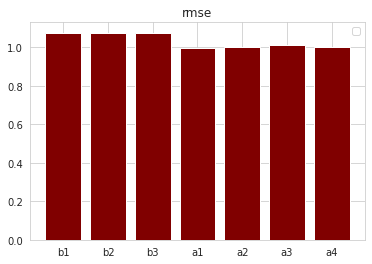

In [98]:
plt.bar(list_model, list_rmse, color='maroon')
plt.title('rmse')
plt.legend()
plt.show()

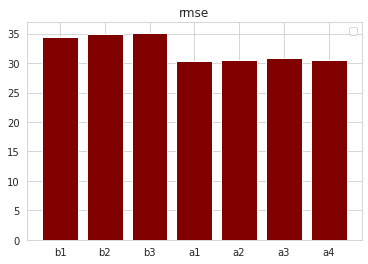

In [99]:
plt.bar(list_model, list_mape, color='maroon')
plt.title('rmse')
plt.legend()
plt.show()

In [100]:
from sklearn import metrics

In [149]:
fpr_b1, tpr_b1, _ = metrics.roc_curve(rating_b1, prediction_b1, pos_label = 1)
fpr_b2, tpr_b2, _ = metrics.roc_curve(rating_b2, prediction_b2, pos_label = 1)
fpr_b3, tpr_b3, _ = metrics.roc_curve(rating_b3, prediction_b3, pos_label = 1)
fpr_a1, tpr_a1, _ = metrics.roc_curve(rating_a1, prediction_a1, pos_label = 1)
fpr_a2, tpr_a2, _ = metrics.roc_curve(rating_a2, prediction_a2, pos_label = 1)
fpr_a3, tpr_a3, _ = metrics.roc_curve(rating_a3, prediction_a3, pos_label = 1)
fpr_a4, tpr_a4, _ = metrics.roc_curve(rating_a4, prediction_a4, pos_label = 1)

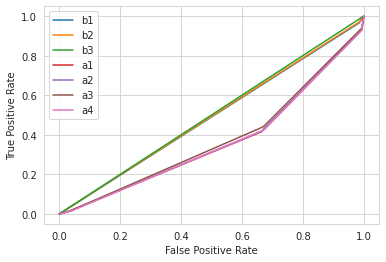

In [150]:
plt.plot(fpr_b1,tpr_b1, label = 'b1')
plt.plot(fpr_b2,tpr_b2, label = 'b2')
plt.plot(fpr_b3,tpr_b3, label = 'b3')
plt.plot(fpr_a1,tpr_a1, label = 'a1')
plt.plot(fpr_a2,tpr_a2, label = 'a2')
plt.plot(fpr_a3,tpr_a3, label = 'a3')
plt.plot(fpr_a4,tpr_a4, label = 'a4')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)
plt.show()

Comparing RMSE and MAPE, A1 is the best the model, and b3 is the worst model. Comparing ROC curve, among the baseline model, b3 is the best model. And among the implemented model, a3 is the best model, a4 is the worst model. In summary, a3 is the best model for having lower MAPE and RMSE than the baseline model and having greater accuracy than other implemented model. 

The reason that implemented model is not working well as the baseline model in ROC curve is because not enough training time, even though they already took 12 hours on average. Since the netflix dataset is a very large dataset, it requires more training time to get a more accurate result, all my implemented models did not converged when I stopped them. But implemented model do get better results on RMSE and MAPE when we add bias, implicit feedback and temporal dynamics. Another problem is the new user in testing set. I just assign a new pu and qi to the new user and only use bi from previous training, this might confuse the model and do not get ideal result. All in all, the result did not reach my expectation, my take away from this project is the implementation of those algorithms.
